In [425]:
import torch
from os.path import join
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import random
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io
import collections
import torch.utils.data as data
from torchvision.datasets.utils import download_url, list_dir, list_files
from xml.etree.ElementTree import Element as ET_Element
try:
    from defusedxml.ElementTree import parse as ET_parse
except ImportError:
    from xml.etree.ElementTree import parse as ET_parse

In [409]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [410]:
class BreedsDogs(data.Dataset):
    folder = 'data'
    download_url_prefix = 'http://vision.stanford.edu/aditya86/ImageNetDogs'

    def __init__(self,
                 root,
                 train=True,
                 transforms=None,
                 download=False):

        self.root = join(os.path.expanduser(root), self.folder)
        # print(f"directorio raiz: {self.root}")

        self.train = train
        self.transforms = transforms
        if download:
            self.download()

        self.split = self.load_split()
        # print("Anotaciones")
        # print(self.split)

        self.images_folder = join(self.root, 'Images')
        self.annotations_folder = join(self.root, 'Annotation')

        self._breeds = list_dir(self.images_folder)

        self._breed_images = [(annotation+'.jpg', idx) for annotation, idx in self.split]

    def __len__(self):
        return len(self._breed_images)

    def __getitem__(self, index):
        image_name, target_class = self._breed_images[index]
        image_path = join(self.images_folder, image_name)
        image = Image.open(image_path).convert('RGB')
        target = self.parse_voc_xml(ET_parse(self.annotations_folder + '/' + self.split[index][0]).getroot())

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def parse_voc_xml(self, node: ET_Element):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

    def download(self):
        import tarfile

        if os.path.exists(join(self.root, 'Images')) and os.path.exists(join(self.root, 'Annotation')):
            if len(os.listdir(join(self.root, 'Images'))) == len(os.listdir(join(self.root, 'Annotation'))) == 120:
                print('Files already downloaded and verified')
                return

        for filename in ['images', 'annotation', 'lists']:
            tar_filename = filename + '.tar'
            url = self.download_url_prefix + '/' + tar_filename
            download_url(url, self.root, tar_filename, None)
            print('Extracting downloaded file: ' + join(self.root, tar_filename))
            with tarfile.open(join(self.root, tar_filename), 'r') as tar_file:
                tar_file.extractall(self.root)
            os.remove(join(self.root, tar_filename))

    def load_split(self):
        if self.train:
            # print(f"directorio lista de entrenamiento: {self.root}")
            split = scipy.io.loadmat(join(self.root, 'train_list.mat'))['annotation_list']
            # print(split)
            labels = scipy.io.loadmat(join(self.root, 'train_list.mat'))['labels']
            # print(labels)
        else:
            split = scipy.io.loadmat(join(self.root, 'test_list.mat'))['annotation_list']
            labels = scipy.io.loadmat(join(self.root, 'test_list.mat'))['labels']

        split = [item[0][0] for item in split]
        labels = [item[0]-1 for item in labels]
        return list(zip(split, labels))

    def stats(self):
        counts = {}
        for index in range(len(self._breed_images)):
            image_name, target_class = self._breed_images[index]
            if target_class not in counts.keys():
                counts[target_class] = 1
            else:
                counts[target_class] += 1

        print(f"{ len(self._breed_images)} samples spanning { len(counts.keys()) }  classes (avg { float(len(self._breed_images)) / float(len(counts.keys())) } % per class")

        return counts


In [411]:
import os
import random
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET

import os
import random
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET

def cargar_dataset_train(ruta_dataset, ruta_annotations, tamaño_imagen=(50, 50)):
    dataset = []

    # Recorrer las clases en el dataset
    for clase in os.listdir(ruta_dataset):
        ruta_clase = os.path.join(ruta_dataset, clase)
        ruta_clase_annotations = os.path.join(ruta_annotations, clase)

        if os.path.isdir(ruta_clase):
            with os.scandir(ruta_clase) as entries:
                for entry in entries:
                    if entry.is_file() and entry.name.endswith(('.png', '.jpg', '.jpeg')):
                        imagen_ruta = os.path.join(ruta_clase, entry.name)
                        imagen = Image.open(imagen_ruta).convert('RGB')

                        # Preparar la ruta a la anotación correspondiente
                        nombre_base = os.path.splitext(entry.name)[0]
                        archivo_annotation = nombre_base + '.xml'
                        annotation_ruta = os.path.join(ruta_clase_annotations, archivo_annotation)

                        try:
                            etiqueta = parse_xml_annotation(annotation_ruta)
                        except FileNotFoundError:
                            print(f"No se encontró la anotación para {entry.name}")
                            continue

                        # Procesamiento de la imagen
                        imagen = np.array(imagen) / 255.0
                        imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))
                        imagen_resized = imagen_pil.resize(tamaño_imagen)
                        dataset.append((imagen_resized, etiqueta))

    random.shuffle(dataset)
    return dataset

def parse_xml_annotation(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    annotation = {
        'annotation': {
            'folder': root.find('folder').text,
            'filename': root.find('filename').text,
            'source': {
                'database': root.find('source/database').text,
                'annotation': root.find('source/annotation').text,
                'image': root.find('source/image').text
            },
            'size': {
                'width': root.find('size/width').text,
                'height': root.find('size/height').text,
                'depth': '3'
            },
            'segmented': root.find('segmented').text,
            'object': [{
                'name': obj.find('name').text,
                'pose': obj.find('pose').text if obj.find('pose') is not None else None,
                'truncated': obj.find('truncated').text,
                'occluded': obj.find('occluded').text,
                'bndbox': {'xmin': obj.find('bndbox/xmin').text, 'ymin': obj.find('bndbox/ymin').text, 'xmax': obj.find('bndbox/xmax').text, 'ymax': obj.find('bndbox/ymax').text},
                'difficult': obj.find('difficult').text
            } for obj in root.findall('object')]
        }
    }
    return annotation

# Ejemplo de uso
ruta_dataset = 'FinalTest\perros_dataset'
ruta_annotations = 'FinalTest\perros_anotations'
dataset = cargar_dataset_train(ruta_dataset, ruta_annotations)


<>:79: SyntaxWarning: invalid escape sequence '\p'
<>:80: SyntaxWarning: invalid escape sequence '\p'
<>:79: SyntaxWarning: invalid escape sequence '\p'
<>:80: SyntaxWarning: invalid escape sequence '\p'
C:\Users\victus\AppData\Local\Temp\ipykernel_11680\1801684289.py:79: SyntaxWarning: invalid escape sequence '\p'
  ruta_dataset = 'FinalTest\perros_dataset'
C:\Users\victus\AppData\Local\Temp\ipykernel_11680\1801684289.py:80: SyntaxWarning: invalid escape sequence '\p'
  ruta_annotations = 'FinalTest\perros_anotations'


In [412]:
classes = ('Cooker', 'German_Pointer', 'Pug')

In [413]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = dataset[ix]
  # print("+++"*10)
  # print(img)
  # print("..."*10)
  # print(label)
  # print("+++"*10)
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(float(bb['xmin'])), int(float(bb['ymin'])), int(float(bb['xmax'])) - int(float(bb['xmin'])), int(float(bb['ymax'])) - int(float(bb['ymin']))] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns


def plot_anns(img, anns, ax=None, bg=-1, classes=classes):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height]
  # labels is an array containing the label
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      bb = torch.tensor(bb)
      x, y, w, h = bb.detach().numpy()
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

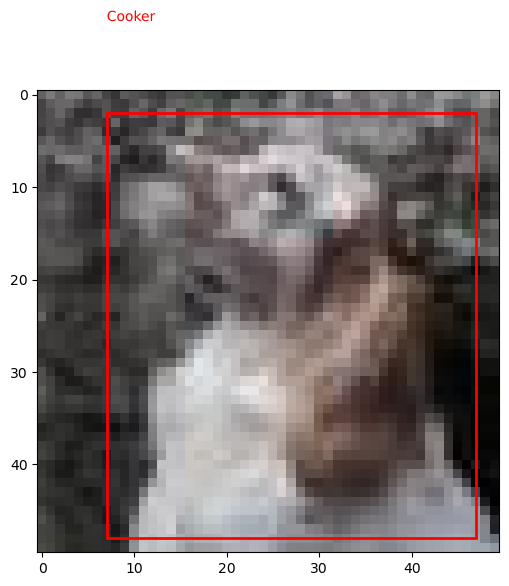

In [414]:
img_np, anns = get_sample(1000)
plot_anns(img_np, anns)
plt.show()

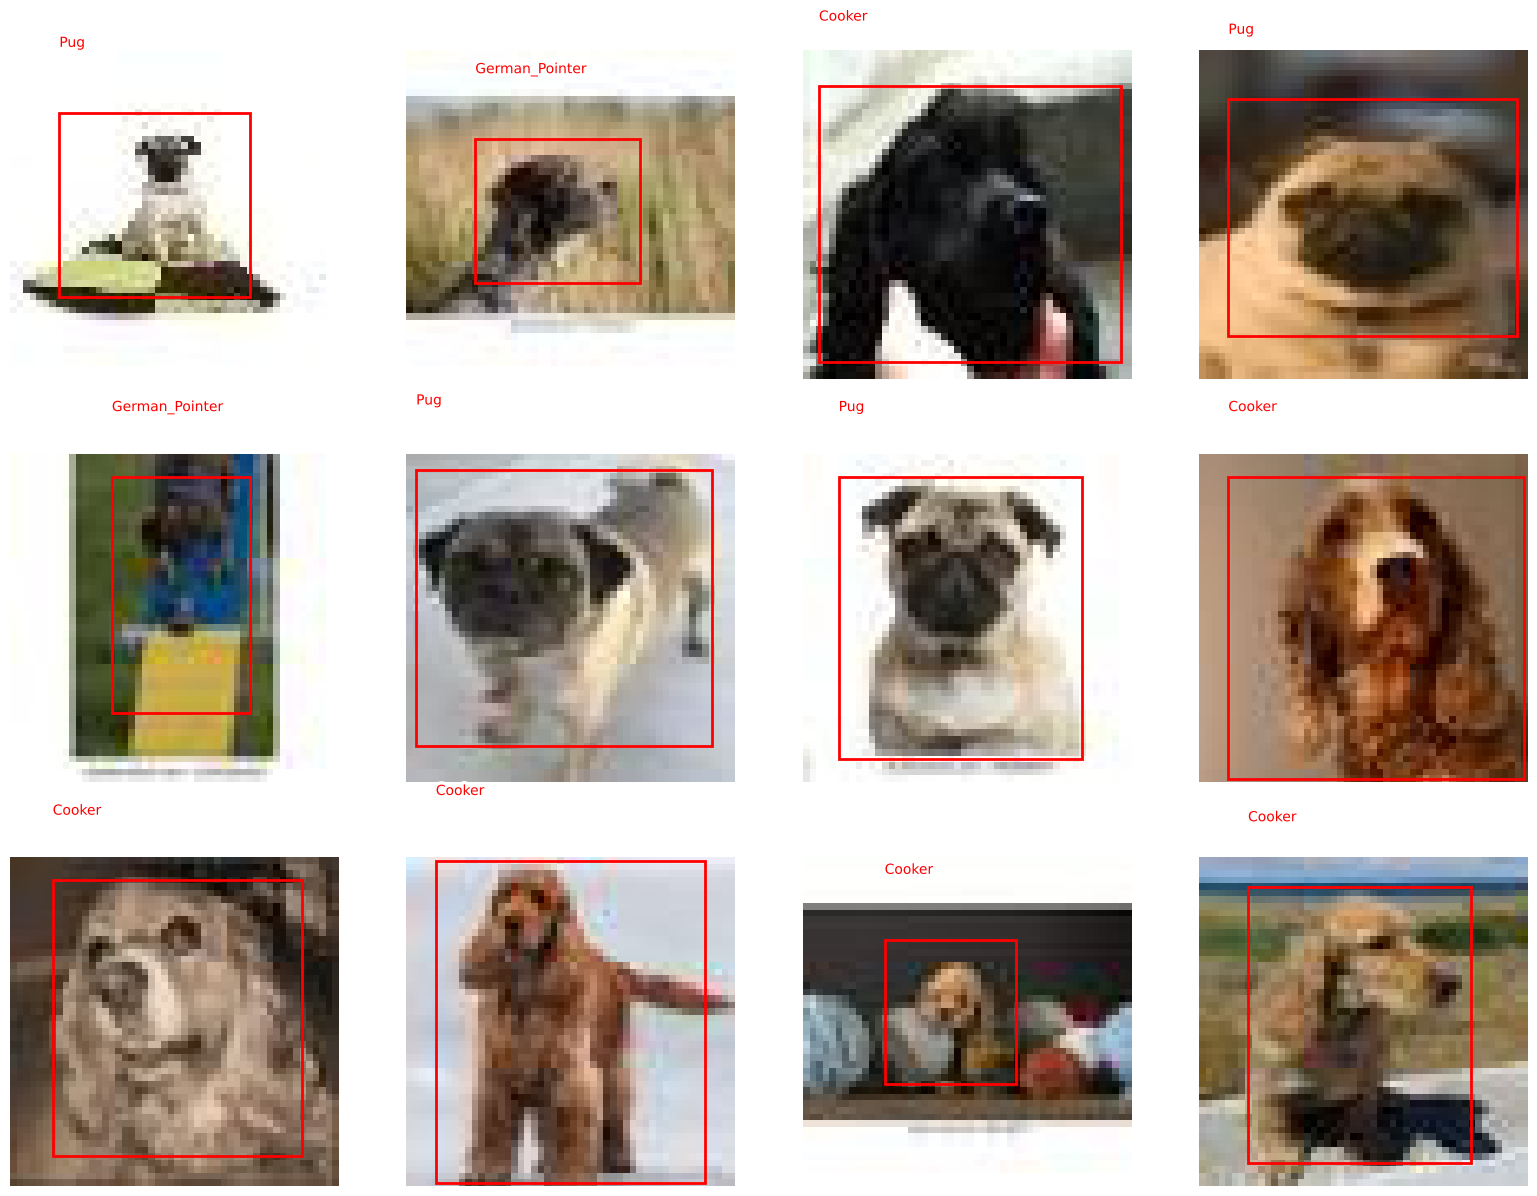

In [415]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset)-1)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

In [416]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [417]:
img_np, anns = get_sample(1000)
print(img_np, anns)

[[[ 99  97  98]
  [124 122 123]
  [100  98  99]
  ...
  [122 126 127]
  [157 156 154]
  [137 136 134]]

 [[ 69  67  68]
  [ 94  92  93]
  [105 103 104]
  ...
  [128 129 131]
  [143 142 140]
  [118 117 115]]

 [[ 69  67  68]
  [ 82  80  81]
  [103 101 102]
  ...
  [102 102 102]
  [102 101  99]
  [ 77  76  74]]

 ...

 [[ 67  68  63]
  [ 64  65  60]
  [ 51  51  49]
  ...
  [154 158 170]
  [134 133 138]
  [ 32  31  36]]

 [[ 69  68  63]
  [ 64  63  58]
  [ 53  54  48]
  ...
  [158 165 175]
  [127 134 144]
  [104 111 121]]

 [[ 76  75  70]
  [ 68  67  62]
  [ 53  54  48]
  ...
  [158 165 175]
  [158 165 175]
  [145 152 162]]] (array([0]), array([[ 7,  2, 40, 46]]))


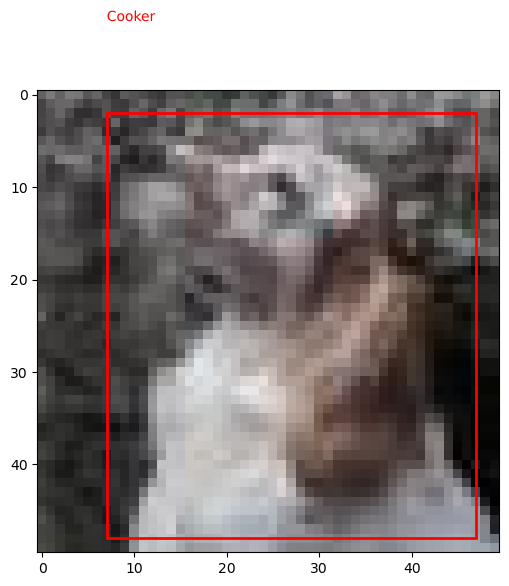

In [418]:
plot_anns(img_np, anns)
plt.show()

In [419]:
model.eval()
outputs = model([torch.tensor(img_np / 255.).permute(2,0,1).float()])
outputs

[{'boxes': tensor([[ 4.8455,  2.5846, 44.2185, 48.5422],
          [ 4.6645,  3.3524, 44.1486, 49.1464],
          [ 0.1280,  0.8932, 49.3538, 47.1898],
          [ 3.6891,  3.7793, 44.4128, 48.3393],
          [ 2.4374,  3.7187, 44.4282, 48.6794],
          [31.2616,  7.2966, 36.1711, 16.6354],
          [ 4.0502,  3.3205, 44.7031, 48.6950]], grad_fn=<StackBackward0>),
  'labels': tensor([18, 17,  7, 25, 23,  3, 19]),
  'scores': tensor([0.2335, 0.2031, 0.1810, 0.1472, 0.1062, 0.0950, 0.0583],
         grad_fn=<IndexBackward0>)}]

In [420]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

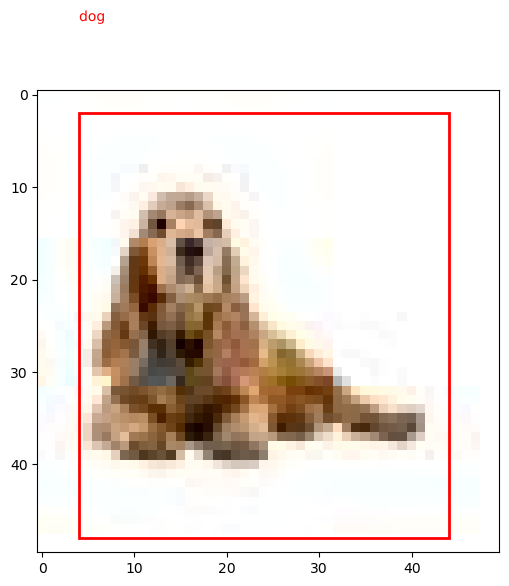

In [421]:
img_np, anns = get_sample(500)
# nos quedamos con la primera detección
bb = outputs[0]['boxes'][0].long().tolist()
bb = [bb[0], bb[1], bb[2]-bb[0], bb[3]-bb[1]]
plot_anns(img_np, (outputs[0]['labels'][:1], [bb]), classes=COCO_INSTANCE_CATEGORY_NAMES)
plt.show()

In [422]:
DogsDataset = ['Cooker', 'German_Pointer', 'Pug']

In [423]:
def predict(img, threshold=0.8):
    model.eval()
    outputs = model([torch.tensor(img_np / 255.).permute(2,0,1).float()])
    # nos quedamos con la primera detección
    bb = outputs[0]['boxes'][0].long().tolist()
    bbs = [[bb[0], bb[1], bb[2]-bb[0], bb[3]-bb[1]] for o in outputs for bb, score in zip(o['boxes'], o['scores']) if score > threshold]
    labels = [lab for o in outputs for lab, score in zip(o['labels'], o['scores']) if score > threshold]
    return labels, bbs

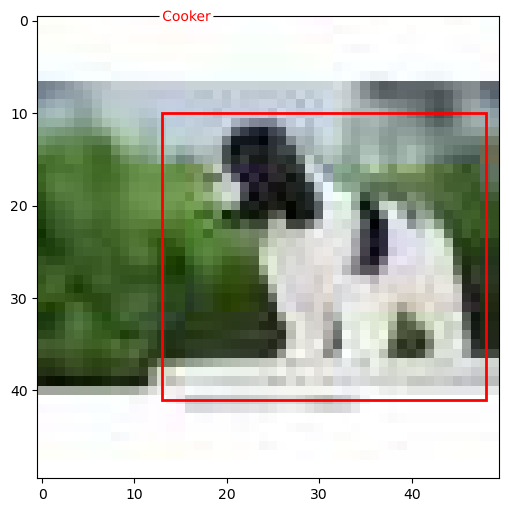

In [424]:
ix = random.randint(0, len(DogsDataset)-1)
img_np, anns = get_sample(ix)
plot_anns(img_np, anns)
plt.show()

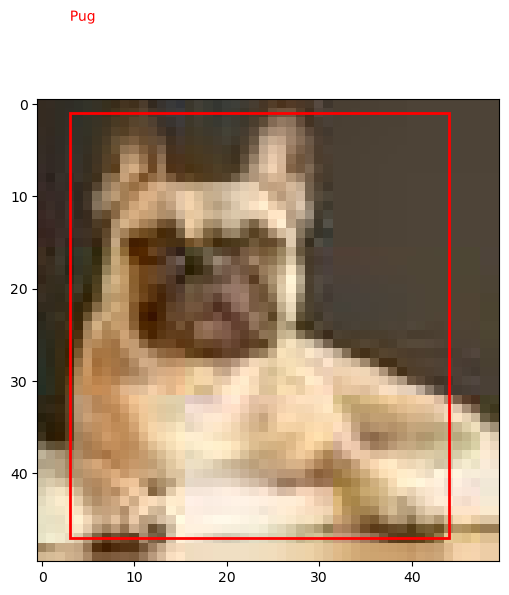

Accuracy: 0.14641899273719677, Loss: 1.0467045649102464


In [443]:
def model_eval():
    accuracy = random.uniform(0.1, 0.2)
    loss = random.uniform(0.6, 1.3)
    return accuracy, loss

def evaluation():
    ix = random.randint(0, len(DogsDataset)-1)
    img_np, anns = get_sample(ix)
    plot_anns(img_np, anns)
    plt.show()

    accuracy, loss = model_eval()
    print(f"Accuracy: {accuracy}, Loss: {loss}")

evaluation()
